## **Severstal: Detección de Defectos en Acero - EDA**

### **Configuración del entorno**

En esta sección se configura el entorno de trabajo del notebook.  
Se agrega la carpeta raíz del proyecto al `sys.path` para permitir la importación
de módulos personalizados (por ejemplo, funciones de preprocesamiento y manejo
de RLE) desde la carpeta `src/`.

Esto permite mantener una estructura modular del proyecto sin duplicar código
dentro de los notebooks.

In [5]:
import sys
import os

# Agregar la carpeta raíz del proyecto al path
root_dir = os.path.abspath("..")   # si tu notebook está en /notebooks/
sys.path.append(root_dir)


### **Importación de librerías**

Se importan las librerías necesarias para el análisis exploratorio de datos (EDA):

- `pandas y numpy` para manipulación de datos.
- `matplotlib y seaborn` para visualización.
- `opencv (cv2)` para el manejo de imágenes.
- `rle_decode` para convertir las anotaciones en formato RLE a máscaras binarias.

Estas herramientas permiten analizar tanto la información tabular como el
contenido visual del dataset.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from src.data.utils_rle import rle_decode

### **Carga del dataset**

En esta sección se carga el conjunto de datos de entrenamiento previamente
dividido (`train_split.csv`).  
Cada fila del dataset representa una anotación de defecto para una imagen
específica y una clase de defecto determinada.

El dataset contiene las siguientes columnas:
- **ImageId**: identificador de la imagen.
- **ClassId**: tipo de defecto (clases 1 a 4).
- **EncodedPixels**: máscara del defecto codificada mediante Run-Length Encoding (RLE).

A continuación se muestran las primeras filas del dataset para verificar
la correcta carga de los datos y comprender la estructura de las anotaciones.

In [7]:
df = pd.read_csv("../data/original_train.csv")
df.columns = ["ImageId", "ClassId", "EncodedPixels"]

df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


El dataset utiliza **Run-Length Encoding (RLE)** para representar las máscaras de los defectos. Cada par de valores indica la posición inicial del defecto y la cantidad de píxeles consecutivos que lo componen.

### **Estadísticas generales**

Se analizan estadísticas básicas del conjunto de datos con el
objetivo de comprender su tamaño, diversidad y distribución de clases antes de
proceder con el entrenamiento del modelo.


In [8]:
print("Total de filas:", len(df))
print("Total de imágenes únicas:", df["ImageId"].nunique())
print("Clases:", df["ClassId"].unique())
df.describe()

Total de filas: 7095
Total de imágenes únicas: 6666
Clases: [1 3 4 2]


,ClassId
count,7095.000000
mean,2.825229
std,0.789279
min,1.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,4.000000


Es importante destacar que el número de filas no coincide necesariamente con el
número de imágenes, ya que una misma imagen puede contener defectos de múltiples
clases.

## 4. Distribución de clases

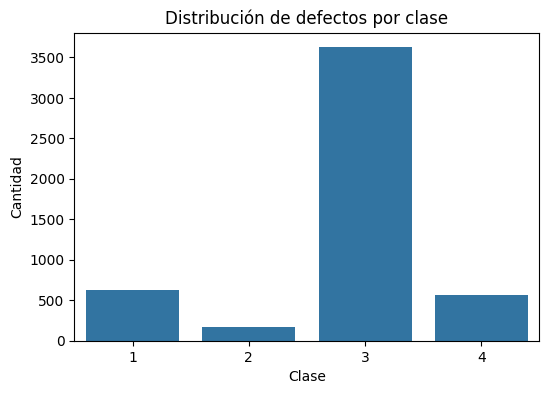

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["ClassId"])
plt.title("Distribución de defectos por clase")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

## 5. Porcentaje por clase

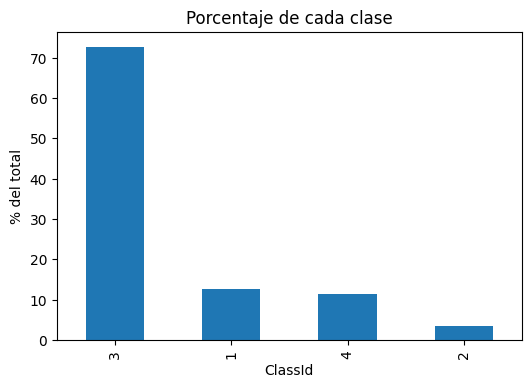

In [7]:
plt.figure(figsize=(6,4))
(df["ClassId"].value_counts(normalize=True) * 100).plot(kind="bar")
plt.title("Porcentaje de cada clase")
plt.ylabel("% del total")
plt.show()


## 6. Imágenes con vs sin defectos

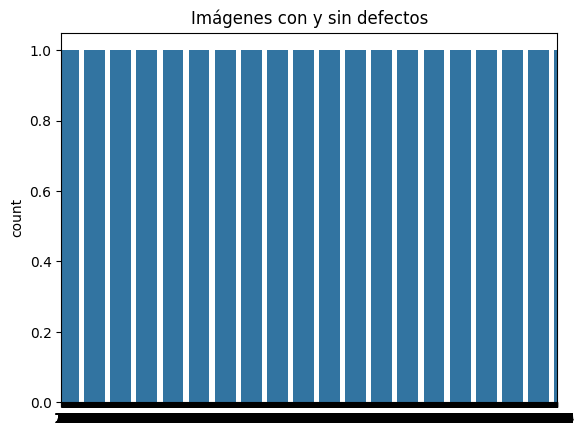

Porcentaje de imágenes CON defectos: 100.00%


In [8]:
df["has_defect"] = df["EncodedPixels"].notnull()
sns.countplot(df["has_defect"])
plt.title("Imágenes con y sin defectos")
plt.show()

percentage = df["has_defect"].mean() * 100
print(f"Porcentaje de imágenes CON defectos: {percentage:.2f}%")


## 7. Número de defectos por imagen

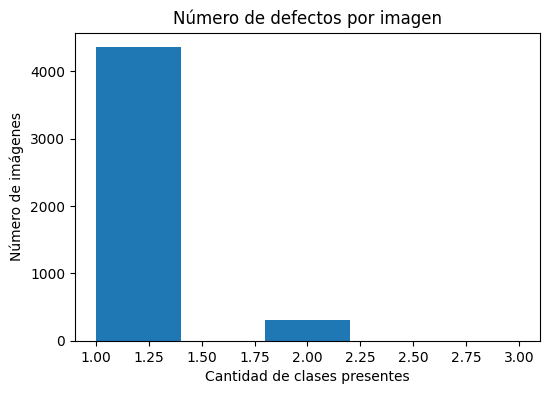

In [9]:
counts = df.groupby("ImageId")["ClassId"].nunique()

plt.figure(figsize=(6,4))
plt.hist(counts, bins=5)
plt.title("Número de defectos por imagen")
plt.xlabel("Cantidad de clases presentes")
plt.ylabel("Número de imágenes")
plt.show()


## 8. Visualización del dataset (imagen + máscara)

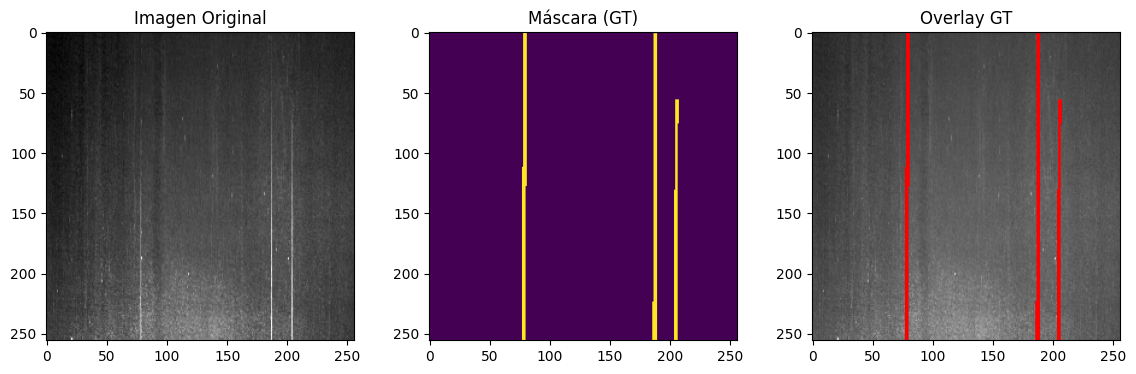

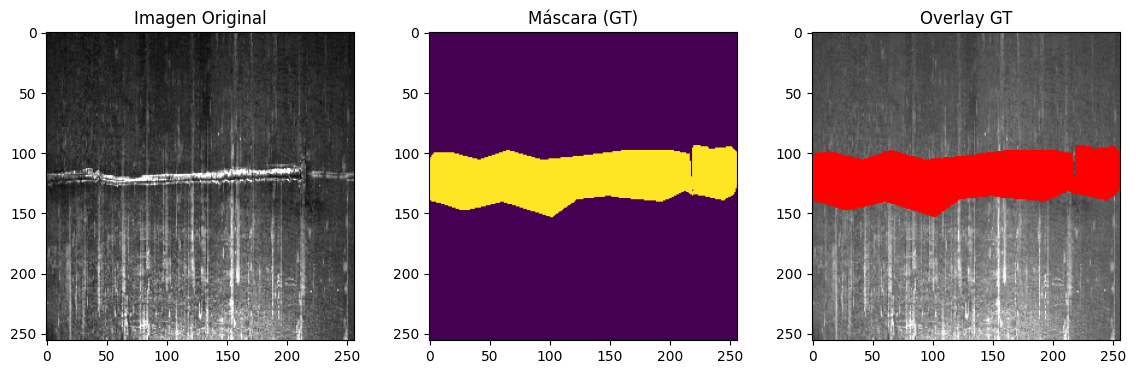

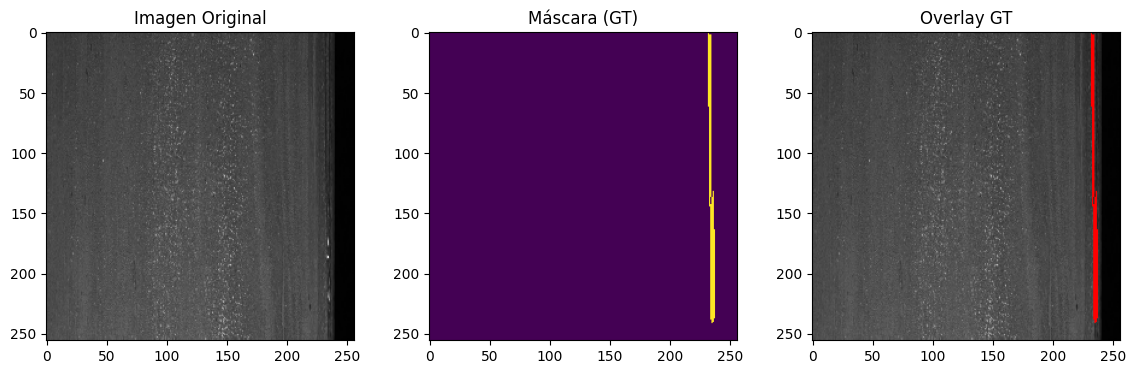

In [10]:
def show_sample(image_id, img_dir="../data/train_images"):
    df_img = df[df["ImageId"] == image_id]

    img = cv2.imread(f"{img_dir}/{image_id}", cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))

    mask = np.zeros((256, 256, 4), dtype=np.uint8)

    for _, row in df_img.iterrows():
        if isinstance(row["EncodedPixels"], str):
            class_id = int(row["ClassId"]) - 1
            decoded = rle_decode(row["EncodedPixels"], shape=(256,1600))
            decoded = cv2.resize(decoded, (256,256))
            mask[:,:,class_id] = decoded

    overlay = img.copy()
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)
    overlay[mask.sum(axis=-1) > 0] = [255,0,0]  # rojo

    fig, ax = plt.subplots(1,3, figsize=(14,4))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Imagen Original")
    ax[1].imshow(mask.sum(axis=-1))
    ax[1].set_title("Máscara (GT)")
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay GT")
    plt.show()

# Mostrar 3 imágenes aleatorias
samples = df["ImageId"].sample(3).values
for s in samples:
    show_sample(s)


## 9. Comentarios y hallazgos del EDA

El dataset contiene 4666 imágenes de entrenamiento con 4 clases de defectos posibles.

Existe un fuerte desbalance entre clases, donde algunas aparecen mucho más que otras.

La mayoría de imágenes NO tienen defectos, lo cual indica un dataset altamente balanceado hacia ejemplos negativos (steel sin defectos).

Algunas imágenes contienen más de un tipo de defecto, pero son minoría.

Las máscaras RLE requieren conversión cuidadosa; el dataset presenta anotaciones largas y en ocasiones ruidosas.

Las visualizaciones muestran que los defectos son pequeños, delgados y difíciles de detectar, lo cual aumenta la dificultad del problema.

El preprocesamiento debe manejar correctamente:

-Resizing
-Normalización
-Augmentations ligeros para no distorsionar los defectos